# Library Setting

In [1]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import gc
gc.collect()

0

<br></br>

# Configuration

In [2]:
class CFG:
    SEED = 0
    
    SUBSET_DEPTH = 2
    INTERACTION = False
    FS_ALPHA = 0.01
    
    N_SPLITS = 5
    TARGET_TRANSFORMATION = ['log','sqrt'][0]
    
    LR = 0.003
    EPOCHS = 30000
    ES = 300
    XGB_LR = 0.01     # default=0.3
    XGB_EPOCHS = 3000 # default=100
    XGB_ES = 100
    XTRATREES_EPOCHS = 100 #default=100

<br></br>

# Data

## Data Load

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [4]:
train_df.shape, test_df.shape

((57920, 15), (14480, 14))

In [5]:
train_df.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


<br>

## Target Transformation

In [6]:
if CFG.TARGET_TRANSFORMATION=='log':
    train_df['가격'] = np.log(train_df['가격'])
elif CFG.TARGET_TRANSFORMATION=='sqrt':
    train_df['가격'] = np.sqrt(train_df['가격'])

<br>

## Resetting Columns Type

In [7]:
class TypeResetting:
    def __init__(self):
        self.cat_features = ['브랜드','차량모델명','판매도시','판매구역','생산년도','모델출시년도']
        self.seg_features = []
        
    def add_categorical_features(self,cat_features):
        self.cat_features += cat_features
        
    def delete_categorical_features(self,cat_features):
        self.cat_features = [col for col in self.cat_features if col not in cat_features]
        
    def add_segment_features(self,segment_features):
        self.seg_features = ['segment']
        self.cat_features = [col for col in self.cat_features if col not in segment_features]
        
    def fit(self,data):
        if (len(self.seg_features)>0) & ('segment' not in data.columns):
            raise ValueError("segment column name must be 'segment'")
        self.target_feature = ['가격']
        self.unuse_features = ['ID']
        self.dummy_features = ['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드']
        self.num_features   = [col for col in data.columns
                               if col not in self.target_feature+self.unuse_features+self.dummy_features+self.cat_features+self.seg_features]
        
    def transform(self,data):
        d = data.copy()
        for col in self.dummy_features:
            if d[col].dtypes!=int:
                d[col] = d[col].astype(int)
        for col in self.cat_features:
            if d[col].dtypes!=object:
                d[col] = d[col].astype(str)
        for col in self.num_features:
            if d[col].dtypes!=float:
                d[col] = d[col].astype(float)
        for col in self.seg_features:
            if d[col].dtypes!=object:
                d[col] = d[col].astype(str)
        for col in self.unuse_features:
            if col in d.columns:
                d.drop(col,axis=1,inplace=True)
        return d
    
    def fit_transform(self,data):
        self.fit(data)
        return self.transform(data)
    
    def get_feature_type(self):
        globals()['target_feature'] = self.target_feature
        globals()['unuse_features'] = self.unuse_features
        globals()['dummy_features'] = self.dummy_features
        globals()['cat_features']   = self.cat_features
        globals()['num_features']   = self.num_features

In [8]:
type_resetor = TypeResetting()
type_resetor.fit(train_df)
type_resetor.get_feature_type()

train_df2 = type_resetor.transform(train_df)
test_df2  = type_resetor.transform(test_df)

<br></br>

# New Features

In [9]:
# pd.Series([str(round(int(year)/100,1)) for year in train_df6['생산년도']]).value_counts()

In [10]:
train_df2.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054


In [11]:
from tqdm import tqdm
from itertools import chain, combinations

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def has_test_only_value(train,test,group):
    tr_uniques = ['_'.join(x) for x in train[group].drop_duplicates().values]
    te_uniques = ['_'.join(x) for x in test [group].drop_duplicates().values]
    test_only = list(set(te_uniques)-set(tr_uniques))
    _has_test_only = False if len(test_only)==0 else True
    return _has_test_only

class FeatureEngineering:
    def __init__(self):
        pass
    
    def _get_quantile(self,x,col):
        x = np.array(x).flatten()
        x = x[pd.notnull(x)]

        agg_df = pd.DataFrame(index=[0])
        agg_df[f'{col}_Avg'] = np.mean(x)
        for q in [25,50,75]:
            agg_df[f'{col}_Q{q}'] = np.quantile(x,q/100)

        return agg_df
    
    def _derived_features(self,data):
        d = data.copy()

        # (1) 모델출시년도에 생산된 차량인지
        d['출시년도생산여부'] = np.where(d['생산년도'].astype(int)==d['모델출시년도'].astype(int),1,0)

        # (2) 모델출시 이후에 몇년 지나서 생산됬는지
        d['출시이후생산년수'] = d['생산년도'].astype(int)-d['모델출시년도'].astype(int)

        # (3) 출시 이전에 생산되었는지
        d['출시이전생산여부'] = np.where(d['출시이후생산년수']<0,1,0)

        # (4) 브랜드의 국적 (구글링)
        d['브랜드국적'] = ['체코' if brand=='skoda' else
                        '일본' if brand in ['toyota','nissan','mazda','honda','mitsubishi'] else
                        '독일' if brand in ['mercedes-benz','audi','volkswagen','bmw','opel'] else
                        '이탈리아' if brand=='fiat' else
                        '프랑스' if brand in ['renault','citroen','peugeot'] else
                        '미국' if brand=='ford' else
                        '한국' if brand in ['kia','hyundai'] else
                        '스페인' if brand=='seat' else
                        '스웨덴' if brand=='volvo' else
                        np.nan for brand in d['브랜드']]

        # (5) 브랜드 국적의 대륙명
        d['브랜드대륙명'] = ['유럽' if country in ['체코','독일','이탈리아','프랑스','스페인','스웨덴'] else
                          '아시아' if country in ['일본','한국'] else
                          '아메리카' if country in ['미국'] else
                          np.nan for country in d['브랜드국적']]
        return d
    
    def fit(self,data,test_data=None,cat_features=[],subset_depth=1):
        assert len(cat_features)>=subset_depth, \
            'len(cat_features) >= subset_depth'
        
        self.cat_features = cat_features
        self.new_cat_features = ['출시년도생산여부','출시이후생산년수','출시이전생산여부','브랜드국적','브랜드대륙명']
        
        # (6) 카테고리 변수에 따른 가격의 Quantile값
        all_subset_list = all_subsets(cat_features)
        all_subset_list = [subset for subset in all_subset_list if (len(subset)<=subset_depth) & (len(subset)>=1)]
        
        print(f'> Get quantiles of target by categorical features (depth={subset_depth})')
        self.agg_dict = {}
        pbar = tqdm(all_subset_list)
        for subset in pbar:
            subset = list(subset)
            if test_data is not None:
                if has_test_only_value(data,test_data,subset):
                    pass
                else:
                    pbar.set_description('Subset: {}'.format(' + '.join(subset)))
                    subset_name = '_'.join(subset)
                    agg_fn = data.groupby(subset)['가격'].apply(lambda x: self._get_quantile(x,subset_name)).reset_index()
                    drop_cols = [col for col in agg_fn if col.find('level_')>=0]
                    agg_fn.drop(columns=drop_cols,inplace=True)
                    if agg_fn.isnull().sum().sum()>0:
                        print('> Null Detectd: {} -> Passed'.format('+'.join(subset)))
                    else:
                        self.agg_dict[subset_name] = agg_fn
            
    def transform(self,data):
        data = self._derived_features(data)
        null_cnt = data.isnull().sum().sum()
        for key,agg_fn in self.agg_dict.items():
            data = pd.merge(data,agg_fn,how='left',on=key.split('_'))
        return data
    
    def fit_transform(self,data,test_data=None,cat_features=[],subset_depth=1):
        self.fit(data,cat_features,subset_depth)
        return self.transform(data)

In [12]:
fe = FeatureEngineering()
fe.fit(
    data=train_df2,
    test_data=test_df2,
    cat_features=cat_features, 
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df3 = fe.transform(train_df2)
test_df3  = fe.transform(test_df2)

> Get quantiles of target by categorical features (depth=2)


Subset: 브랜드 + 판매구역: 100%|██████████| 21/21 [00:00<00:00, 21.42it/s] 


In [13]:
train_df3.shape, train_df2.shape

((57920, 43), (57920, 14))

In [14]:
fe.new_cat_features

['출시년도생산여부', '출시이후생산년수', '출시이전생산여부', '브랜드국적', '브랜드대륙명']

In [15]:
type_resetor = TypeResetting()
type_resetor.add_categorical_features(fe.new_cat_features)
type_resetor.fit(train_df3)
type_resetor.get_feature_type()

train_df3 = type_resetor.transform(train_df3)
test_df3  = type_resetor.transform(test_df3)

In [16]:
print(train_df3.shape)
train_df3.head()

(57920, 43)


,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,모델출시년도_Avg,모델출시년도_Q25,모델출시년도_Q50,모델출시년도_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970,0,4,0,일본,아시아,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.436879,3.089678,3.348851,3.785779,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760,1,0,0,독일,유럽,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,2.930286,2.453588,2.826722,3.353407,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422,0,5,0,일본,아시아,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,2.794236,2.341806,2.738903,3.095125,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054,1,0,0,이탈리아,유럽,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.605269,3.249210,3.626206,3.948741,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024


In [17]:
assert (train_df3.isnull().sum().sum()==0) & (test_df3.isnull().sum().sum()==0),\
    "null detected"

In [18]:
train_df3.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,모델출시년도_Avg,모델출시년도_Q25,모델출시년도_Q50,모델출시년도_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970,0,4,0,일본,아시아,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.436879,3.089678,3.348851,3.785779,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760,1,0,0,독일,유럽,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,2.930286,2.453588,2.826722,3.353407,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422,0,5,0,일본,아시아,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,2.794236,2.341806,2.738903,3.095125,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054,1,0,0,이탈리아,유럽,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.605269,3.249210,3.626206,3.948741,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024


<br></br>

# EDA

In [19]:
# check_num_features = [col for col in num_features if col.find('_Q')<0]

# i=0
# for col in check_num_features:
#     i+=1
#     print('\n({}/{}) {}'.format(i,len(check_num_features),col))
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df3['가격'],y=train_df3[col])
#     plt.show()

<br></br>

# Add the Interaction Term

In [20]:
import warnings
from tqdm import trange

def get_abs_corr(x,y):
    return np.abs(np.corrcoef(x,y))[0,1]

class InteractionTerm:
    def __init__(self):
        pass
    
    def fit(self,data,num_features,corr_cutoff=0.7):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        
        d = data.copy()
        self.interaction_list = []
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    col_i = num_features[i]
                    col_j = num_features[j]
                    
                    # 상관계수가 cutoff보다 큰 경우에는 interaction을 생성하지 않음
                    if (get_abs_corr(d[col_i]*d[col_j],d[col_i])>=corr_cutoff) | (get_abs_corr(d[col_i]*d[col_j],d[col_j])>=corr_cutoff):
                        pass
                    else:
                        self.interaction_list.append(f'{col_i}*{col_j}')
    
    def transform(self,data):
        d = data.copy()
        for interaction in self.interaction_list:
            col_i,col_j = interaction.split('*')
            d[interaction] = d[col_i]*d[col_j]
        return d
    
    def fit_transform(self,data,num_features,corr_cutoff=0.7):
        self.fit(data,num_features,corr_cutoff)
        return self.transform(data)

In [21]:
train_df4 = train_df3.copy()
test_df4  = test_df3.copy()

if CFG.INTERACTION:
    interaction_maker = InteractionTerm()
    interaction_maker.fit(
        data=train_df3,
        num_features=num_features,
        corr_cutoff=0.7,
    )
    train_df4 = interaction_maker.transform(train_df4)
    test_df4  = interaction_maker.transform(test_df4)

    type_resetor = TypeResetting()
    type_resetor.add_categorical_features(fe.new_cat_features)
    type_resetor.fit(train_df4)
    type_resetor.get_feature_type()

    train_df4 = type_resetor.transform(train_df4)
    test_df4  = type_resetor.transform(test_df4)

In [22]:
train_df4.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,모델출시년도_Avg,모델출시년도_Q25,모델출시년도_Q50,모델출시년도_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75
0,2018,2014,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044
1,2010,2006,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970,0,4,0,일본,아시아,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.436879,3.089678,3.348851,3.785779,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760,1,0,0,독일,유럽,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,2.930286,2.453588,2.826722,3.353407,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280
3,2006,2001,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422,0,5,0,일본,아시아,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,2.794236,2.341806,2.738903,3.095125,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082
4,2007,2007,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054,1,0,0,이탈리아,유럽,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.605269,3.249210,3.626206,3.948741,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024


<br></br>

# Feature Selection

In [23]:
# k=0
# for i in range(len(num_features)):
#     for j in range(len(num_features)):
#         if i>j:
#             col_i = num_features[i]
#             col_j = num_features[j]
#             corr = np.corrcoef(train_df4[col_i],train_df4[col_j])[0,1]
#             if corr>=0.7:
#                 k+=1
#                 print(k,col_i,col_j,corr)

In [24]:
def log_offset(x):
    if min(x)>0:
        offset = 0
    elif min(x)==0:
        offset = 1e-3
    else:
        offset = min(x)+1e-3
        print('minimum = {:.3f}'.format(min(x)))
    return np.log(x+offset)

<br></br>

## Categorical Features

In [25]:
# import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [26]:
check_cat_features = [col for col in cat_features if train_df4[col].nunique()<=100]

# (1) ANOVA를 해서 p-value가 0.05보다 높은 것들 확인
pvalue_list = []
for col in tqdm(check_cat_features):
    d = train_df4[[col,'가격']].rename(columns={col:'feature'})
    
    model = ols(f'가격 ~ C(feature)',data=d).fit()
    pvalue = anova_lm(model).values[0][-1]
    pvalue_list.append([col,pvalue])
    
pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
    .sort_values('pvalue',ascending=False)
# pvalue_df[pvalue_df.pvalue>=alpha].round(4)

100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


In [27]:
# (2) (1)에서 유의하지않은 feature들은 log적용 후에도 유의하지 않으면 제외
pvalue_list2 = []
unsignificant_features = pvalue_df[pvalue_df.pvalue>CFG.FS_ALPHA].feature.tolist()
for col in tqdm(unsignificant_features):
    d = train_df4[[col,'target']].rename(columns={col:'feature'})
    d['feature'] = log_offset(d['feature'])
    
    model = ols(f'feature ~ C(target)',data=d).fit()
    pvalue = anova_lm(model).values[0][-1]
    pvalue_list2.append([col,pvalue])
    
pvalue_df2 = pd.DataFrame(pvalue_list2,columns=['feature','pvalue'])\
    .sort_values('pvalue',ascending=False)

0it [00:00, ?it/s]


In [28]:
delete_features = pvalue_df2[pvalue_df2.pvalue> CFG.FS_ALPHA].feature.tolist()
log_features    = pvalue_df2[pvalue_df2.pvalue<=CFG.FS_ALPHA].feature.tolist()
print('> delete_features')
print('  - length : {}'.format(len(delete_features)))
print('  - feature_name : {}'.format(delete_features))
print('')
print('> log_features')
print('  - length : {}'.format(len(log_features)))
print('  - feature_name : {}'.format(log_features))

train_df5 = train_df4.copy()
train_df5.drop(delete_features,axis=1,inplace=True)
for col in log_features:
    train_df5[col] = log_offset(train_df5[col])
    
test_df5 = test_df4.copy()
test_df5.drop(delete_features,axis=1,inplace=True)
for col in log_features:
    test_df5[col] = log_offset(test_df5[col])

> delete_features
  - length : 0
  - feature_name : []

> log_features
  - length : 0
  - feature_name : []


<br>

## Numerical Features

In [29]:
import scipy

In [30]:
# (1) corr test를 해서 p-value가 0.05보다 높은 것들 확인
pvalue_list = []
for col in num_features:
    corr,pvalue = scipy.stats.pearsonr(train_df5['가격'],train_df5[col])
    pvalue_list.append([col,pvalue])
pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
    .sort_values('pvalue',ascending=False)
# pvalue_df.round(4).head()

In [31]:
# (2) (1)에서 유의하지않은 feature들은 log적용 후에도 유의하지 않으면 제외
pvalue_list2 = []
unsignificant_features = pvalue_df[pvalue_df.pvalue>CFG.FS_ALPHA].feature.tolist()
for col in tqdm(unsignificant_features):
    corr,pvalue = scipy.stats.pearsonr(train_df5['가격'],log_offset(train_df5[col]))
    pvalue_list2.append([col,pvalue])
pvalue_df2 = pd.DataFrame(pvalue_list2,columns=['feature','pvalue'])\
    .sort_values('pvalue',ascending=False)
# pvalue_df2.round(4).head()

0it [00:00, ?it/s]


In [32]:
delete_features = pvalue_df2[pvalue_df2.pvalue> CFG.FS_ALPHA].feature.tolist()
log_features    = pvalue_df2[pvalue_df2.pvalue<=CFG.FS_ALPHA].feature.tolist()
print('> delete_features')
print('  - length : {}'.format(len(delete_features)))
print('  - feature_name : {}'.format(delete_features))
print('')
print('> log_features')
print('  - length : {}'.format(len(log_features)))
print('  - feature_name : {}'.format(log_features))

train_df6 = train_df5.copy()
train_df6.drop(delete_features,axis=1,inplace=True)
for col in log_features:
    train_df6[col] = log_offset(train_df6[col])
    
test_df6 = test_df5.copy()
test_df6.drop(delete_features,axis=1,inplace=True)
for col in log_features:
    test_df6[col] = log_offset(test_df6[col])

> delete_features
  - length : 0
  - feature_name : []

> log_features
  - length : 0
  - feature_name : []


<br></br>

# Make Segment

In [33]:
def make_segment(data,segment: list):
    d = data.copy()
    d['segment'] = d[segment].apply(lambda x: '___'.join(x),axis=1)
    d.drop(columns=segment,inplace=True)
    return d

In [34]:
segment = ['브랜드']
train_df7 = make_segment(train_df6,segment)
test_df7  = make_segment(test_df6 ,segment)

In [35]:
test_only = list(set(test_df7.segment.unique())-set(train_df7.segment.unique()))
assert len(test_only)==0, \
    "Segment exists only in the test set ({})".format(len(test_only))

In [36]:
train_only = list(set(train_df7['segment'].unique())-set(test_df7['segment'].unique()))

n_asis = len(train_df7)
n_tobe = len(train_df7[~train_df7.segment.isin(train_only)])
train_df7 = train_df7[~train_df7.segment.isin(train_only)]
print('> Train에만 존재하는 Segment 제거')
print(' - 데이터수 : {:,} -> {:,}'.format(n_asis,n_tobe))
print(' - 세그먼트수 : {:,}'.format(train_df7['segment'].nunique()))

> Train에만 존재하는 Segment 제거
 - 데이터수 : 57,920 -> 57,920
 - 세그먼트수 : 20


In [37]:
vc = train_df7['segment'].value_counts().sort_values()
display(vc.head())
print('...')
display(vc.tail())

segment
mitsubishi     556
peugeot        793
citroen       1129
fiat          1164
volvo         1352
Name: count, dtype: int64

...


segment
bmw           5262
audi          5597
volkswagen    5693
ford          5819
opel          6651
Name: count, dtype: int64

In [38]:
type_resetor = TypeResetting()
type_resetor.add_categorical_features(fe.new_cat_features)
type_resetor.add_segment_features(segment)
type_resetor.fit(train_df7)
type_resetor.get_feature_type()

train_df7 = type_resetor.transform(train_df7)
test_df7  = type_resetor.transform(test_df7)

In [39]:
cat_features

['차량모델명',
 '판매도시',
 '판매구역',
 '생산년도',
 '모델출시년도',
 '출시년도생산여부',
 '출시이후생산년수',
 '출시이전생산여부',
 '브랜드국적',
 '브랜드대륙명']

In [40]:
train_df7.head()

,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,모델출시년도_Avg,모델출시년도_Q25,모델출시년도_Q50,모델출시년도_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment
0,2018,2014,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044,skoda
1,2010,2006,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970,0,4,0,일본,아시아,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.436879,3.089678,3.348851,3.785779,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479,toyota
2,2002,2002,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760,1,0,0,독일,유럽,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,2.930286,2.453588,2.826722,3.353407,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280,mercedes-benz
3,2006,2001,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422,0,5,0,일본,아시아,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,2.794236,2.341806,2.738903,3.095125,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082,nissan
4,2007,2007,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054,1,0,0,이탈리아,유럽,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.605269,3.249210,3.626206,3.948741,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024,fiat


<br></br>

# Outlier Detection

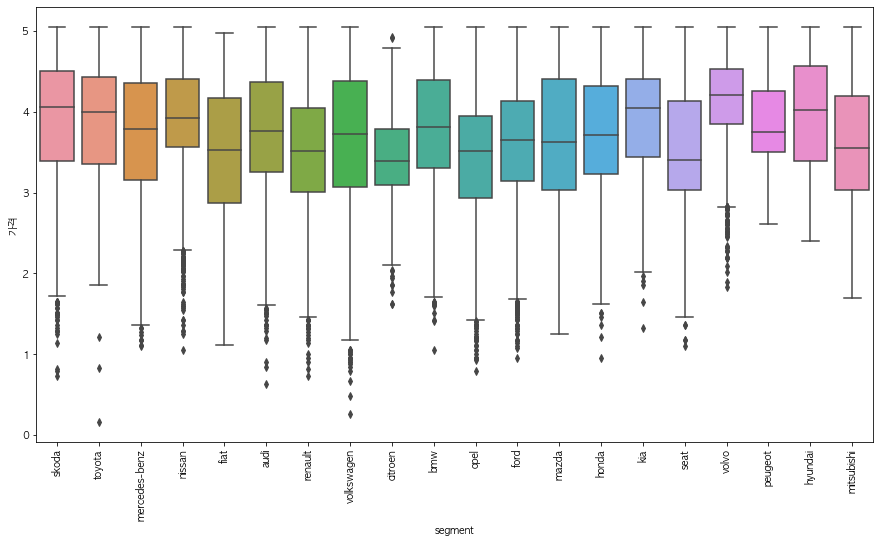

In [41]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train_df7['segment'],y=train_df7['가격'])
plt.xticks(rotation=90)
plt.show()

In [42]:
# Q1,Q3를 기준으로 1.5 IQR보다 멀리있는 값들을 Outlier로 판단하여 제거함
class OutlierDetect:
    def __init__(self,data,target_feature,group=None):
        assert target_feature in data.columns, \
            "No {} column in the data".format(target_feature)
        self.data = data
        self.target_feature = target_feature
        self.group = group
    
    def _get_outlier(self,data,target_feature,whis):
        target = data[target_feature]
        q1,q3 = target.quantile([0.25,0.75]).values
        outlier_lower = q1 - whis*(q3-q1)
        outlier_upper = q3 + whis*(q3-q1)
        outlier_boundary = [
            outlier_lower,
            outlier_upper,
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum(),
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum() / len(target),
            len(target),
        ]
        return outlier_boundary
    
    def fit(self,whis=1.5):
        if self.group is None:
            outlier_boundary = self._get_outlier(self.data,self.target_feature,whis)
            self.outlier_boundary = pd.DataFrame(
                [outlier_boundary],
                columns=['outlier_lower','outlier_upper','n_outlier','p_outlier','n_total'],
            )
        else:
            self.group_list = self.data[self.group].unique()
            outlier_boundary_list = []
            for group in self.group_list:
                d = self.data[self.data[self.group]==group]
                outlier_boundary = [group]+self._get_outlier(d,self.target_feature,whis)
                outlier_boundary_list.append(outlier_boundary)
            self.outlier_boundary = pd.DataFrame(
                outlier_boundary_list,
                columns=['group','outlier_lower','outlier_upper','n_outlier','p_outlier','n_total'],
            )
    
    def transform(self,data,max_example=4):
        example = []
        if self.group is None:
            if len(self.outlier_boundary_df)!=1:
                raise ValueError('length of self.outlier_boundary_df must be 1')
            else:
                d = data.copy()
                outlier_lower = self.outlier_boundary.outlier_lower.values[0]
                outlier_upper = self.outlier_boundary.outlier_upper.values[0]
                outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                new_data = d[outlier_in]
                ex = d[self.target_feature][~outlier_in]
                if len(ex)>0:
                    ex = sorted([round(e,3) for e in ex])
                    if len(ex)>max_example:
                        ex = ex[:2]+['...']+ex[-2:]
                else:
                    ex = ''
                example.append(ex)
        else:
            check_1 = list(set(self.group_list)-set(data[self.group].unique()))
            check_2 = list(set(data[self.group].unique())-set(self.group_list))
            if (len(check_1)==0) & (len(check_2)==0):
                pass
            elif (len(check_1)>0) & (len(check_2)==0):
                pass
            else:
                raise ValueError('Unknown group values')
            
            new_data = []
            for group in self.group_list:
                d = data[data[self.group]==group]
                outlier_d = self.outlier_boundary[self.outlier_boundary['group']==group]
                if len(outlier_d)!=1:
                    raise ValueError('length of self.outlier_boundary_df must be 1')
                else:
                    outlier_lower = outlier_d.outlier_lower.values[0]
                    outlier_upper = outlier_d.outlier_upper.values[0]
                    outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                    new_d = d[outlier_in]
                    new_data.append(new_d)
                    ex = d[self.target_feature][~outlier_in]
                    if len(ex)>0:
                        ex = sorted([round(e,3) for e in ex])
                        if len(ex)>max_example:
                            ex = ex[:2]+['...']+ex[-2:]
                    else:
                        ex = ''
                    example.append(ex)
            new_data = pd.concat(new_data,axis=0)
        
        self.outlier_boundary['example'] = example
        self.example = example
        
        print("> {:,}'s outliers deleted ({:,}->{:,})".format(len(data)-len(new_data),len(data),len(new_data)))
        return new_data
    
    def fit_transform(self,data,whis=1.5,max_example=4):
        self.fit(whis)
        return self.transform(data)

In [43]:
outlier_detector = OutlierDetect(
    data=train_df7,
    target_feature='가격',
    group='segment',
)
train_df8 = outlier_detector.fit_transform(
    data=train_df7,
    whis=2.5,
    max_example=4,
)
test_df8 = test_df7.copy()

> 12's outliers deleted (57,920->57,908)


In [44]:
outlier_detector.outlier_boundary.round(3)

,group,outlier_lower,outlier_upper,n_outlier,p_outlier,n_total,example
0,skoda,0.605,7.298,0,0.000,3130,
1,toyota,0.649,7.140,1,0.000,3259,[0.157]
2,mercedes-benz,0.148,7.359,0,0.000,2899,
3,nissan,1.440,6.524,7,0.003,2129,"[1.051, 1.256, ..., 1.426, 1.426]"
4,fiat,-0.408,7.448,0,0.000,1164,
5,audi,0.453,7.174,0,0.000,5597,
6,renault,0.401,6.647,0,0.000,3853,
7,volkswagen,-0.202,7.655,0,0.000,5693,
8,citroen,1.349,5.526,0,0.000,1129,
9,bmw,0.588,7.102,0,0.000,5262,


In [45]:
print(train_df8.shape)
train_df8.head()

(57908, 43)


,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,모델출시년도_Avg,모델출시년도_Q25,모델출시년도_Q50,모델출시년도_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment
0,2018,2014,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044,skoda
8,2018,2014,fabia,OPO,OPO,98514.0,1000.0,0,0,1,0,0,4.131480,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.728235,3.212053,3.785779,4.331391,4.320785,4.019486,4.355041,4.643140,3.470557,2.933059,3.712352,4.065687,4.079683,3.558201,4.355041,4.631812,skoda
34,2016,2015,superb,MYS,SLA,164900.0,1968.0,0,1,0,0,0,4.738564,0,1,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,4.339726,3.903229,4.537641,4.772399,3.734607,3.206803,3.773910,4.355041,4.577404,4.405499,4.617790,4.791733,4.339726,3.903229,4.537641,4.772399,3.910907,3.477232,4.021236,4.525044,skoda
55,2009,2008,superb,PDO,MAL,187000.0,1798.0,0,0,1,0,0,3.728100,0,1,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,4.339726,3.903229,4.537641,4.772399,3.715470,3.201526,3.755837,4.305416,3.676310,3.330417,3.594569,3.966085,4.339726,3.903229,4.537641,4.772399,3.872676,3.407494,3.995258,4.450503,skoda
93,2017,2013,octavia,OLS,WAR,40569.0,999.0,0,0,1,0,0,4.419684,0,4,0,체코,유럽,3.881733,3.393501,4.057853,4.509072,3.975385,3.459466,4.269697,4.509430,3.591944,3.147165,3.554491,4.123094,4.359707,4.172385,4.403910,4.591781,3.975385,3.459466,4.269697,4.509430,3.782668,3.147165,4.050964,4.465563,skoda


<br></br>

# Modeling

In [46]:
import os
def mkdir(paths):
    if type(paths)==str:
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            print('> Create Folder: {}'.format(path))
            os.mkdir(path)

In [47]:
## dummy_features는 한가지만 속함
# X[dummy_features].apply(lambda x: np.sum(x),axis=1).value_counts()

def add_fuel_type(data,dummy_features):
    d = data.copy()
    d['fuel_type'] = d[dummy_features].apply(
        lambda x: dummy_features[np.where(x==1)[0][0]],axis=1)
    d.drop(columns=dummy_features,inplace=True)
    return d

In [48]:
mkdir('./model_checkpoints')
mkdir('./model_checkpoints/segment_catboost')
mkdir('./model_checkpoints/segment_weightedensemble')

In [49]:
assert (train_df8.isnull().sum().sum()==0) & (test_df8.isnull().sum().sum()==0),\
    "null detected"

<br>

## CatBoost
- public score : 

In [50]:
gc.collect()

14234

In [51]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

In [52]:
train_fn = train_df8.copy()
test_fn  = test_df8 .copy()

In [ ]:
%%time
# 1시간

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X = add_fuel_type(X,dummy_features)
new_cat_features = cat_features + ['fuel_type']

segment_list = X['segment'].unique()

models = {}
feature_info = {}
scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X = X[X.segment==segment].drop('segment',axis=1)
    _y = y[X.segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in new_cat_features if col in _X.columns]
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        
        # kfold dataset
        X_tr, X_va = _X.iloc[tr_idx], _X.iloc[val_idx]
        y_tr, y_va = _y.iloc[tr_idx], _y.iloc[val_idx]

        # progress
        progress = 'Segment: [{}], Size: [{:,}], KFold: [{}/{}]'\
            .format(segment,len(_X),k,CFG.N_SPLITS)
        pbar.set_description(progress)

        # dataset
        train_dataset = Pool(X_tr,y_tr,cat_features=fixed_cat_features)
        valid_dataset = Pool(X_va,y_va,cat_features=fixed_cat_features)

        # define the model
        model = CatBoostRegressor(
            loss_function='MAE',
            random_state=CFG.SEED,
            iterations=CFG.EPOCHS,
            learning_rate=CFG.LR,
            allow_writing_files=False,
        )

        # fit the model
        model.fit(
            train_dataset,
            eval_set=valid_dataset,
            early_stopping_rounds=CFG.ES,
            verbose=0,
            #metric_period=CFG.EPOCHS//5,
        )

        # save the model
        model.save_model(f'./model_checkpoints/segment_catboost/{segment}_k{k}.cbm')

        # prediction
        y_pred = model.predict(valid_dataset).flatten()
        y_true = y_va.values
        
        # inverse transform
        if CFG.TARGET_TRANSFORMATION=='log':
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_true)
        elif CFG.TARGET_TRANSFORMATION=='sqrt':
            y_pred = np.square(y_pred)
            y_true = np.square(y_true)
            
        # calculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {'cat_features':fixed_cat_features,'features':_X.columns.tolist()}
    
    # score report
    mean_score_report = pd.Series(np.array(_scores)[:,-1]).astype(float).mean()
    print('Segment: {}'.format(segment))
    print("MAE's for {}-Fold: [{}]".format(CFG.N_SPLITS,np.array(pd.Series(np.array(_scores)[:,-1]).astype(float).values)))
    print("Mean of MAE's for {}-Fold: [{:.4f}]".format(CFG.N_SPLITS,mean_score_report))

In [ ]:
score_df = pd.DataFrame(
    np.array(scores).reshape(len(scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)
score_df[['k','n_tr','n_val','score']] = score_df[['k','n_tr','n_val','score']].astype(float)
score_df.sort_values(['segment','k']).head(10)

# score_df.groupby('segment')[['n_tr','n_val','score']].mean().sort_values('score')

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
X = add_fuel_type(X,dummy_features)
y = train_fn[target_feature]

X_test = add_fuel_type(test_fn,dummy_features)

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data = X[X.segment==segment][feature_info[segment]['features']]
    train_dataset = Pool(train_data,cat_features=feature_info[segment]['cat_features'])
    # (2) test
    test_data = X_test[X_test.segment==segment][feature_info[segment]['features']]
    test_dataset = Pool(test_data,cat_features=feature_info[segment]['cat_features'])
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## Target Transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
        tr_pred_df['pred'] = np.exp(tr_pred_df['pred'])
        te_pred_df['pred'] = np.exp(te_pred_df['pred'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
        tr_pred_df['pred'] = np.square(tr_pred_df['pred'])
        te_pred_df['pred'] = np.square(te_pred_df['pred'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

In [ ]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

In [ ]:
a = pd.read_csv('./out/15_ensemble_stacking_segment_브랜드_kfold_logy_interaction_.csv')['가격']
b = te_pred_df.pred.values

mean_absolute_error(a,b)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/17_catboost_segment_브랜드_kfold_logy_outlierdetection.csv',index=False)

<br>

## Weighted Ensemble
- public score : 

In [61]:
import pandas as pd
import warnings

class OneHotEncoder:
    def __init__(self):
        pass
    
    def fit(self,data,columns):
        self.transform_list = []
        for col in columns:
            for i,value in enumerate(sorted(data[col].unique())):
                if i>0:
                    self.transform_list.append([col,value])
        
    def transform(self,data):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        new_data = data.copy()
        for col,value in self.transform_list:
            new_data[f'{col}_{value}'] = np.where(new_data[col]==value,1,0)
        drop_columns = pd.unique(np.array(self.transform_list)[:,0])
        new_data.drop(columns=drop_columns,inplace=True)
        return new_data

In [71]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,weight=['equal','balanced'],transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.weight = weight
        self.transform = transform
        self._get_regressors()
    
    def _get_regressors(self):
        max_depth = 10
        n_jobs = -1
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 0.0, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : n_jobs,
            #'max_iter' : 50000,
            'tol' : 0.001,
        }
        
        params_catboost = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : max_depth,
            #'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XGB_EPOCHS,
            'early_stopping_rounds' : CFG.XGB_ES,
            'learning_rate' : CFG.XGB_LR,
            'objective' : 'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
    
        params_lightgbm = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.EPOCHS,
            'early_stopping_round' : CFG.ES,
            'learning_rate' : CFG.LR,
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XTRATREES_EPOCHS,
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : max_depth,
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost),
            #XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            'ElasticNet',
            'CatBoost',
            #'XGBoost',
            'LightGBM',
            #'ExtraTrees',
        ]
        
    def _adjust_prediction(self,pred,minimum_value,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.exp(np.array(pred).flatten())
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.cat_features = cat_features
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name=='ElasticNet':
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='CatBoost':
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=CFG.EPOCHS//5,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                regressor.fit(
                    X_oh,y,
                    eval_set=[(X_val_oh,y_val)],
                    verbose=0,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                regressor.fit(
                    X_tmp,y,
                    eval_set=[(X_val_tmp,y_val)],
                    verbose=-1,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_true = np.array(y)      .flatten()
            va_true = np.array(y_val)  .flatten()
            tr_pred = np.array(tr_pred).flatten()
            va_pred = np.array(va_pred).flatten()
            
            if self.transform is not None:
                tr_true = self.transform(tr_true)
                va_true = self.transform(va_true)
                tr_pred = self.transform(tr_pred)
                va_pred = self.transform(va_pred)
                
            tr_score = mean_absolute_error(y_pred=tr_pred,y_true=tr_true)
            va_score = mean_absolute_error(y_pred=va_pred,y_true=va_true)
            e = time.time()
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: score={:.3f}, val_score={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        ens_tr_score = mean_absolute_error(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = mean_absolute_error(y_true=va_true,y_pred=va_pred)
        
        total_fit_progress = 'Weighted Ensemble({}): score={:.3f}, val_score={:.3f}, elasped={:.1f}s'\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(total_fit_progress)
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name=='CatBoost':
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            y_pred = self._adjust_prediction(y_pred,self.minimum_value,self.maximum_value)
            
            pred_list.append(y_pred)
            
        final_pred = np.zeros(len(X))
        for pred,weight in zip(pred_list,self.weights):
            final_pred += np.array(pred)*weight
            
        if self.transform is not None:
            final_pred = self.transform(np.array(final_pred))
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'target_transformation' : self.target_transformation,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.target_transformation = save_dict['target_transformation'],
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']

In [72]:
def transform(x,func=['log','sqrt']):
    if func=='log':
        y = np.exp(x)
    elif func=='sqrt':
        y = np.square(x)
    else:
        raise ValueError('Unknown func')
    return y

In [73]:
from sklearn.model_selection import KFold

In [74]:
gc.collect()

509

In [75]:
train_fn = train_df8.copy()
test_fn  = test_df8 .copy()

In [76]:
%%time
# 3시간

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)

segment_list = X['segment'].unique()

models = {}
feature_info = {}
scores = []

s_i = 0
for segment in segment_list:
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X    = X   [X   .segment==segment].drop('segment',axis=1)
    _X_oh = X_oh[X_oh.segment==segment].drop('segment',axis=1)
    _y    = y   [X   .segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            weight='balanced',
            transform=lambda x: transform(x,func=CFG.TARGET_TRANSFORMATION),
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(f'./model_checkpoints/segment_weightedensemble/{segment}_k{k}.pickle')

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = y_va.values
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }

--------------------------------------------------------------------------------
> [1/20] Segment: skoda, Length: 3130
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/3] ElasticNet : score=6.526, val_score=7.015, elasped=15.5s


KeyboardInterrupt: 

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data    = X   [X   .segment==segment][feature_info[segment]['features']]
    train_data_oh = X_oh[X_oh.segment==segment][feature_info[segment]['oh_features']]
    # (2) test
    test_data     = X_test   [X_test   .segment==segment][feature_info[segment]['features']]
    test_data_oh  = X_test_oh[X_test_oh.segment==segment][feature_info[segment]['oh_features']]
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'true':y[X.segment==segment].values.flatten(),
    })
    for i in range(len(kfold_models)):
        tr_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(train_data,train_data_oh)
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame()
    for i in range(len(kfold_models)):
        te_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(test_data,test_data_oh)
    te_pred_df.index = test_data.index
        
    ## target transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
tr_pred_df.to_parquet('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_outlierdetection.parquet')
te_pred_df.to_parquet('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_outlierdetection.parquet')

In [ ]:
tr_pred_df.to_csv('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_outlierdetection.csv',index=False)
te_pred_df.to_csv('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_outlierdetection.csv',index=False)

<br></br>

## Stacking

<br>

(2) ensemble regressor : 5.6378198138	

In [ ]:
new_cat_features = cat_features + ['fuel_type']

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
X = add_fuel_type(X,dummy_features)
y = train_fn[target_feature]

X_test = add_fuel_type(test_fn,dummy_features)

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

In [ ]:
stacking_models = {}
stacking_feature_info = {}
stacking_scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X = X[X.segment==segment].drop('segment',axis=1)
    _y = y[X.segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in new_cat_features if col in _X.columns]
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        
        # kfold dataset
        X_tr, X_va = _X.iloc[tr_idx], _X.iloc[val_idx]
        y_tr, y_va = _y.iloc[tr_idx], _y.iloc[val_idx]

        # progress
        progress = 'Segment: [{}], Size: [{:,}], KFold: [{}/{}]'\
            .format(segment,len(_X),k,CFG.N_SPLITS)
        pbar.set_description(progress)

        # dataset
        train_dataset = Pool(X_tr,y_tr,cat_features=fixed_cat_features)
        valid_dataset = Pool(X_va,y_va,cat_features=fixed_cat_features)

        # define the model
        model = CatBoostRegressor(
            loss_function='MAE',
            random_state=CFG.SEED,
            iterations=CFG.EPOCHS,
            learning_rate=CFG.LR,
            allow_writing_files=False,
        )

        # fit the model
        model.fit(
            train_dataset,
            eval_set=valid_dataset,
            early_stopping_rounds=CFG.ES,
            verbose=0,
            #metric_period=CFG.EPOCHS//5,
        )

        # save the model
        model.save_model(f'./model_checkpoints/segment_catboost/{segment}_k{k}.cbm')

        # prediction
        y_pred = model.predict(valid_dataset).flatten()
        y_true = y_va.values
        
        # inverse transform
        if CFG.TARGET_TRANSFORMATION=='log':
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_true)
        elif CFG.TARGET_TRANSFORMATION=='sqrt':
            y_pred = np.square(y_pred)
            y_true = np.square(y_true)  
            
        # calculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    stacking_models[segment] = _models
    stacking_scores.append(_scores)
    stacking_feature_info[segment] = {'cat_features':fixed_cat_features,'features':_X.columns.tolist()}
    
    # score report
    mean_score_report = pd.Series(np.array(_scores)[:,-1]).astype(float).mean()
    print('Segment: {}'.format(segment))
    print("MAE's for {}-Fold: [{}]".format(CFG.N_SPLITS,np.array(pd.Series(np.array(_scores)[:,-1]).astype(float).values)))
    print("Mean of MAE's for {}-Fold: [{:.4f}]".format(CFG.N_SPLITS,mean_score_report))

In [ ]:
score_df = pd.DataFrame(
    np.array(stacking_scores).reshape(len(stacking_scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)

score_df.sort_values(['segment','k']).head(10)

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
X = add_fuel_type(X,dummy_features)
y = train_fn[target_feature]

X_test = add_fuel_type(test_fn,dummy_features)

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data = X[X.segment==segment][stacking_feature_info[segment]['features']]
    train_dataset = Pool(train_data,cat_features=stacking_feature_info[segment]['cat_features'])
    # (2) test
    test_data = X_test[X_test.segment==segment][stacking_feature_info[segment]['features']]
    test_dataset = Pool(test_data,cat_features=stacking_feature_info[segment]['cat_features'])
    
    ## model
    kfold_models = stacking_models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## Target Transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
        tr_pred_df['pred'] = np.exp(tr_pred_df['pred'])
        te_pred_df['pred'] = np.exp(te_pred_df['pred'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
        tr_pred_df['pred'] = np.square(tr_pred_df['pred'])
        te_pred_df['pred'] = np.square(te_pred_df['pred'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

In [ ]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/18_ensemble_stacking_segment_브랜드_kfold_logy_outlierdetection.csv',index=False)

In [ ]:
# from pycaret import regression

# d = pd.concat([X_tr,y_tr],axis=1).head()

# regression.setup(
#     data=d,
#     target='가격',
#     remove_outliers=False,
#     verbose=True,
#     normalize=False,
#     feature_selection=False,
#     session_id=0,
#     categorical_features=fixed_cat_features,
# )
# best = regression.compare_models(n_select=5,fold=3,sort='MAE')
# # best

# preds = np.array([regression.predict_model(b,X_va)['prediction_label'].values.flatten() for b in best])
# preds = np.mean(preds,axis=0)
# preds.shape

# mean_absolute_error(y_true=np.exp(y_va.values.flatten()),y_pred=np.exp(preds))